In [2]:
import random
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image, ImageDraw
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import metrics
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Get Data

In [16]:
test_df = pd.read_csv('test_simplified.csv')
test_df.shape

(112199, 3)

In [17]:
# Get names of all train csv files with the pattern match below
fnames = glob('train_simplified/*.csv')

In [18]:
rows = 200
# Get n rows from all the csv files and append them into one dataframe
train_df = pd.DataFrame(columns=pd.read_csv(fnames[0], nrows=20).columns)
for name in fnames:
    data = pd.read_csv(name, nrows=rows)
    train_df = train_df.append(data)
train_df = train_df.reset_index().drop('index', axis=1)
# Get only those which were correctly recognized
train_df = train_df[train_df['recognized'] == True]

In [19]:
# Convert the drawing column to matrix
train_df['drawing'] = train_df['drawing'].apply(ast.literal_eval)
test_df['drawing'] = test_df['drawing'].apply(ast.literal_eval)

In [21]:
# train_df.head()
# train_df['recognized'].value_counts()

# Draw Sample

In [22]:
train_df.sample(10)

,countrycode,drawing,key_id,recognized,timestamp,word
10180,CA,"[[[1, 0, 13, 12, 14, 59, 85, 239, 242, 247, 24...",6653756567453696,True,2017-01-24 17:20:35.583030,pants
20804,US,"[[[168, 119, 90, 75, 34, 17, 12, 12, 20, 31, 5...",6607950753824768,True,2017-03-21 00:21:17.095250,frying pan
39478,AR,"[[[5, 4, 23, 23, 25, 48, 49, 44, 3], [249, 209...",6247988559085568,True,2017-01-25 20:48:52.941820,candle
41172,GB,"[[[65, 76, 92, 100, 100, 97, 82, 61, 50, 43, 4...",5546684824158208,True,2017-01-25 15:48:22.486960,tornado
10166,BR,"[[[66, 58, 39, 14, 0, 0, 11, 45, 66, 72, 77, 7...",4599823997075456,True,2017-03-28 03:31:41.766620,pants
11348,DE,"[[[40, 41, 59, 71, 75, 78, 102, 105, 100, 85, ...",6320939383914496,True,2017-01-26 11:49:51.798360,fork
31564,US,"[[[70, 76, 77, 76, 66, 3, 0, 7, 14, 27, 51, 82...",5478579708100608,True,2017-03-21 15:58:53.327450,moustache
52568,AE,"[[[245, 238, 237, 233, 82, 37, 7, 0, 0, 0, 8, ...",5036453425840128,True,2017-03-15 12:38:24.080770,microwave
53786,US,"[[[7, 3, 1, 6, 12, 15, 14, 15, 18, 18, 26, 29,...",4874382499381248,True,2017-03-21 15:24:03.322400,raccoon
9338,AE,"[[[17, 34, 75, 93, 105, 109, 110, 99, 73, 34, ...",5621456291495936,True,2017-03-18 17:15:06.179910,snail


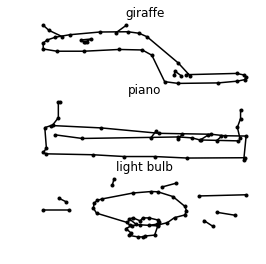

In [23]:
n_samp = 3
train_df_sample = train_df.sample(n_samp)
plt.figure(figsize=(4,4))
for i in range(n_samp):
    draw = train_df_sample.iloc[i]['drawing']
    label = train_df_sample.iloc[i]['word']
    plt.subplot(n_samp,1,i+1)
    for stroke in draw:
        plt.plot(stroke[0], stroke[1], marker='.', color='black')
        plt.title(label)
        plt.axis('off')
plt.show()    

# Convert drawings to images

In [24]:
def draw_it(raw_strokes, output_height, output_width):
    image = Image.new("P", (255,255)
#                       , color=1
            )
    image_draw = ImageDraw.Draw(image)

    for stroke in raw_strokes:
        for i in range(len(stroke[0])-1):

            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=255, width=6)
    # Reduce image size
    image = image.resize((output_height,output_width),Image.ANTIALIAS)
    
    return np.array(image)

In [25]:
output_height = 32
output_width = 32
train_df['img'] = train_df[['drawing']].apply(lambda x: draw_it(x['drawing'], output_height, output_width), axis=1)
test_df['img'] = test_df[['drawing']].apply(lambda x: draw_it(x['drawing'], output_height, output_width), axis=1)

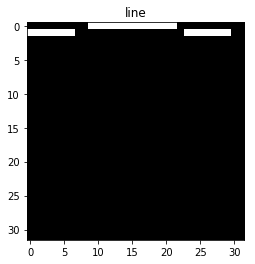

In [26]:
# Show an image
ind = 100
plt.imshow(train_df.iloc[ind]['img'],cmap='gray')
plt.title(train_df.iloc[ind]['word'])
plt.show()

# Create a baseline CNN

In [27]:
batch_size = 10
num_classes = len(fnames)
epochs = 12

### Data Preprocessing

In [28]:
# Shuffle the data
random.seed(111)
train_df = train_df.sample(train_df.shape[0])

In [29]:
# input image dimensions
img_rows, img_cols = output_height, output_width
input_shape = (img_rows, img_cols)

In [30]:
# Reshape the array
imgArr = np.vstack(train_df['img'].values).flatten().reshape((train_df['img'].shape[0], img_rows, img_cols))
imgArr_test = np.vstack(test_df['img'].values).flatten().reshape((test_df['img'].shape[0], img_rows, img_cols))

In [31]:
# In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels] for TF.
# In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In this case, the pixel values are gray scale, the pixel dimension is set to 1.
imgArr = imgArr.reshape(imgArr.shape[0], img_rows, img_cols, 1).astype('float32')
imgArr_test = imgArr_test.reshape(imgArr_test.shape[0], img_rows, img_cols, 1).astype('float32')

In [32]:
y_train = train_df['word']

In [33]:
# Convert class labels from categorical to numerical
unique_classes_list = y_train.unique()
map_class_to_numeric = {k: v for v, k in enumerate(y_train.unique())}
map_numeric_to_class = {v: k for k, v in map_class_to_numeric.iteritems()}
y_train_numeric = y_train.apply(lambda x: map_class_to_numeric[x])

# convert class vectors to binary class matrices
y_train_one_hot = keras.utils.to_categorical(y_train_numeric, num_classes)
num_classes = y_train_one_hot.shape[1]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(imgArr, y_train_one_hot, test_size=0.2)

In [35]:
def top_3_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

### Model Architecture

In [36]:
num_filters = 8 # num of channels / filters
def baseline_conv_model(num_filters):
    model = Sequential()
    model.add(Conv2D(num_filters, (5,5), input_shape=(img_rows,img_cols,1), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*2, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*4, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(2550, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
#     model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy, 'categorical_crossentropy'])
    return model

In [37]:
model = baseline_conv_model(num_filters)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          4640      
__________

In [38]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 50072 samples, validate on 12518 samples
Epoch 1/500
 - 68s - loss: 7.9947 - acc: 0.0041 - top_3_accuracy: 0.0116 - categorical_crossentropy: 7.9947 - val_loss: 5.8167 - val_acc: 0.0064 - val_top_3_accuracy: 0.0166 - val_categorical_crossentropy: 5.8167
Epoch 2/500
 - 64s - loss: 5.6681 - acc: 0.0099 - top_3_accuracy: 0.0267 - categorical_crossentropy: 5.6681 - val_loss: 5.3881 - val_acc: 0.0217 - val_top_3_accuracy: 0.0524 - val_categorical_crossentropy: 5.3881
Epoch 3/500
 - 64s - loss: 5.3259 - acc: 0.0204 - top_3_accuracy: 0.0541 - categorical_crossentropy: 5.3259 - val_loss: 5.1537 - val_acc: 0.0373 - val_top_3_accuracy: 0.0907 - val_categorical_crossentropy: 5.1537
Epoch 4/500
 - 64s - loss: 5.1234 - acc: 0.0341 - top_3_accuracy: 0.0813 - categorical_crossentropy: 5.1234 - val_loss: 4.9477 - val_acc: 0.0584 - val_top_3_accuracy: 0.1298 - val_categorical_crossentropy: 4.9477
Epoch 5/500
 - 65s - loss: 4.9529 - acc: 0.0448 - top_3_accuracy: 0.1062 - categorical_crossentrop

Epoch 40/500
 - 89s - loss: 2.6720 - acc: 0.3366 - top_3_accuracy: 0.5554 - categorical_crossentropy: 2.6720 - val_loss: 2.8432 - val_acc: 0.3306 - val_top_3_accuracy: 0.5403 - val_categorical_crossentropy: 2.8432
Epoch 41/500
 - 91s - loss: 2.6507 - acc: 0.3410 - top_3_accuracy: 0.5595 - categorical_crossentropy: 2.6507 - val_loss: 2.8065 - val_acc: 0.3469 - val_top_3_accuracy: 0.5514 - val_categorical_crossentropy: 2.8065
Epoch 42/500
 - 117s - loss: 2.6165 - acc: 0.3466 - top_3_accuracy: 0.5639 - categorical_crossentropy: 2.6165 - val_loss: 2.8035 - val_acc: 0.3451 - val_top_3_accuracy: 0.5522 - val_categorical_crossentropy: 2.8035
Epoch 43/500
 - 108s - loss: 2.5977 - acc: 0.3501 - top_3_accuracy: 0.5702 - categorical_crossentropy: 2.5977 - val_loss: 2.7907 - val_acc: 0.3450 - val_top_3_accuracy: 0.5577 - val_categorical_crossentropy: 2.7907
Epoch 44/500
 - 110s - loss: 2.5667 - acc: 0.3550 - top_3_accuracy: 0.5768 - categorical_crossentropy: 2.5667 - val_loss: 2.7972 - val_acc: 0.

Epoch 79/500
 - 87s - loss: 1.9500 - acc: 0.4723 - top_3_accuracy: 0.7046 - categorical_crossentropy: 1.9500 - val_loss: 2.8465 - val_acc: 0.3505 - val_top_3_accuracy: 0.5542 - val_categorical_crossentropy: 2.8465
Epoch 80/500
 - 91s - loss: 1.9312 - acc: 0.4727 - top_3_accuracy: 0.7084 - categorical_crossentropy: 1.9312 - val_loss: 2.8785 - val_acc: 0.3456 - val_top_3_accuracy: 0.5524 - val_categorical_crossentropy: 2.8785
Epoch 81/500
 - 83s - loss: 1.9281 - acc: 0.4745 - top_3_accuracy: 0.7077 - categorical_crossentropy: 1.9281 - val_loss: 2.8861 - val_acc: 0.3435 - val_top_3_accuracy: 0.5488 - val_categorical_crossentropy: 2.8861
Epoch 82/500
 - 84s - loss: 1.9136 - acc: 0.4807 - top_3_accuracy: 0.7133 - categorical_crossentropy: 1.9136 - val_loss: 2.9274 - val_acc: 0.3363 - val_top_3_accuracy: 0.5419 - val_categorical_crossentropy: 2.9274
Epoch 83/500
 - 84s - loss: 1.9143 - acc: 0.4792 - top_3_accuracy: 0.7106 - categorical_crossentropy: 1.9143 - val_loss: 2.8392 - val_acc: 0.354

Epoch 118/500
 - 85s - loss: 1.5867 - acc: 0.5533 - top_3_accuracy: 0.7789 - categorical_crossentropy: 1.5867 - val_loss: 2.9684 - val_acc: 0.3486 - val_top_3_accuracy: 0.5529 - val_categorical_crossentropy: 2.9684
Epoch 119/500
 - 89s - loss: 1.5657 - acc: 0.5580 - top_3_accuracy: 0.7827 - categorical_crossentropy: 1.5657 - val_loss: 2.9923 - val_acc: 0.3471 - val_top_3_accuracy: 0.5495 - val_categorical_crossentropy: 2.9923
Epoch 120/500
 - 92s - loss: 1.5623 - acc: 0.5580 - top_3_accuracy: 0.7842 - categorical_crossentropy: 1.5623 - val_loss: 3.0744 - val_acc: 0.3361 - val_top_3_accuracy: 0.5405 - val_categorical_crossentropy: 3.0744
Epoch 121/500
 - 85s - loss: 1.5689 - acc: 0.5591 - top_3_accuracy: 0.7813 - categorical_crossentropy: 1.5689 - val_loss: 3.0486 - val_acc: 0.3418 - val_top_3_accuracy: 0.5453 - val_categorical_crossentropy: 3.0486
Epoch 122/500
 - 85s - loss: 1.5534 - acc: 0.5641 - top_3_accuracy: 0.7871 - categorical_crossentropy: 1.5534 - val_loss: 3.0441 - val_acc: 

Epoch 157/500
 - 86s - loss: 1.3682 - acc: 0.6075 - top_3_accuracy: 0.8217 - categorical_crossentropy: 1.3682 - val_loss: 3.0859 - val_acc: 0.3499 - val_top_3_accuracy: 0.5522 - val_categorical_crossentropy: 3.0859
Epoch 158/500
 - 84s - loss: 1.3695 - acc: 0.6093 - top_3_accuracy: 0.8204 - categorical_crossentropy: 1.3695 - val_loss: 3.1891 - val_acc: 0.3350 - val_top_3_accuracy: 0.5300 - val_categorical_crossentropy: 3.1891
Epoch 159/500
 - 84s - loss: 1.3643 - acc: 0.6107 - top_3_accuracy: 0.8204 - categorical_crossentropy: 1.3643 - val_loss: 3.0955 - val_acc: 0.3497 - val_top_3_accuracy: 0.5459 - val_categorical_crossentropy: 3.0955
Epoch 160/500
 - 87s - loss: 1.3474 - acc: 0.6144 - top_3_accuracy: 0.8231 - categorical_crossentropy: 1.3474 - val_loss: 3.1281 - val_acc: 0.3505 - val_top_3_accuracy: 0.5530 - val_categorical_crossentropy: 3.1281
Epoch 161/500
 - 84s - loss: 1.3596 - acc: 0.6098 - top_3_accuracy: 0.8222 - categorical_crossentropy: 1.3596 - val_loss: 3.1225 - val_acc: 

Epoch 196/500
 - 85s - loss: 1.2154 - acc: 0.6486 - top_3_accuracy: 0.8457 - categorical_crossentropy: 1.2154 - val_loss: 3.2594 - val_acc: 0.3352 - val_top_3_accuracy: 0.5314 - val_categorical_crossentropy: 3.2594
Epoch 197/500
 - 85s - loss: 1.2376 - acc: 0.6403 - top_3_accuracy: 0.8432 - categorical_crossentropy: 1.2376 - val_loss: 3.2979 - val_acc: 0.3351 - val_top_3_accuracy: 0.5275 - val_categorical_crossentropy: 3.2979
Epoch 198/500
 - 84s - loss: 1.2327 - acc: 0.6440 - top_3_accuracy: 0.8452 - categorical_crossentropy: 1.2327 - val_loss: 3.2663 - val_acc: 0.3367 - val_top_3_accuracy: 0.5374 - val_categorical_crossentropy: 3.2663
Epoch 199/500
 - 86s - loss: 1.2301 - acc: 0.6416 - top_3_accuracy: 0.8462 - categorical_crossentropy: 1.2301 - val_loss: 3.2235 - val_acc: 0.3430 - val_top_3_accuracy: 0.5471 - val_categorical_crossentropy: 3.2235
Epoch 200/500
 - 90s - loss: 1.2092 - acc: 0.6462 - top_3_accuracy: 0.8505 - categorical_crossentropy: 1.2092 - val_loss: 3.2106 - val_acc: 

Epoch 235/500
 - 84s - loss: 1.1449 - acc: 0.6661 - top_3_accuracy: 0.8599 - categorical_crossentropy: 1.1449 - val_loss: 3.2671 - val_acc: 0.3418 - val_top_3_accuracy: 0.5358 - val_categorical_crossentropy: 3.2671
Epoch 236/500
 - 84s - loss: 1.1591 - acc: 0.6637 - top_3_accuracy: 0.8592 - categorical_crossentropy: 1.1591 - val_loss: 3.4172 - val_acc: 0.3307 - val_top_3_accuracy: 0.5271 - val_categorical_crossentropy: 3.4172
Epoch 237/500
 - 86s - loss: 1.1368 - acc: 0.6693 - top_3_accuracy: 0.8620 - categorical_crossentropy: 1.1368 - val_loss: 3.3218 - val_acc: 0.3359 - val_top_3_accuracy: 0.5353 - val_categorical_crossentropy: 3.3218
Epoch 238/500
 - 84s - loss: 1.1356 - acc: 0.6692 - top_3_accuracy: 0.8615 - categorical_crossentropy: 1.1356 - val_loss: 3.3091 - val_acc: 0.3358 - val_top_3_accuracy: 0.5419 - val_categorical_crossentropy: 3.3091
Epoch 239/500
 - 86s - loss: 1.1315 - acc: 0.6714 - top_3_accuracy: 0.8630 - categorical_crossentropy: 1.1315 - val_loss: 3.3387 - val_acc: 

Epoch 274/500
 - 85s - loss: 1.0791 - acc: 0.6853 - top_3_accuracy: 0.8713 - categorical_crossentropy: 1.0791 - val_loss: 3.3312 - val_acc: 0.3381 - val_top_3_accuracy: 0.5383 - val_categorical_crossentropy: 3.3312
Epoch 275/500
 - 84s - loss: 1.0618 - acc: 0.6902 - top_3_accuracy: 0.8770 - categorical_crossentropy: 1.0618 - val_loss: 3.3861 - val_acc: 0.3378 - val_top_3_accuracy: 0.5335 - val_categorical_crossentropy: 3.3861
Epoch 276/500
 - 85s - loss: 1.0550 - acc: 0.6920 - top_3_accuracy: 0.8758 - categorical_crossentropy: 1.0550 - val_loss: 3.4180 - val_acc: 0.3319 - val_top_3_accuracy: 0.5283 - val_categorical_crossentropy: 3.4180
Epoch 277/500
 - 83s - loss: 1.0718 - acc: 0.6859 - top_3_accuracy: 0.8743 - categorical_crossentropy: 1.0718 - val_loss: 3.3511 - val_acc: 0.3448 - val_top_3_accuracy: 0.5410 - val_categorical_crossentropy: 3.3511
Epoch 278/500
 - 85s - loss: 1.0659 - acc: 0.6892 - top_3_accuracy: 0.8770 - categorical_crossentropy: 1.0659 - val_loss: 3.3912 - val_acc: 

Epoch 313/500
 - 58s - loss: 0.9898 - acc: 0.7076 - top_3_accuracy: 0.8886 - categorical_crossentropy: 0.9898 - val_loss: 3.4670 - val_acc: 0.3320 - val_top_3_accuracy: 0.5318 - val_categorical_crossentropy: 3.4670
Epoch 314/500
 - 57s - loss: 1.0260 - acc: 0.6997 - top_3_accuracy: 0.8802 - categorical_crossentropy: 1.0260 - val_loss: 3.5120 - val_acc: 0.3298 - val_top_3_accuracy: 0.5260 - val_categorical_crossentropy: 3.5120
Epoch 315/500
 - 57s - loss: 1.0258 - acc: 0.7013 - top_3_accuracy: 0.8803 - categorical_crossentropy: 1.0258 - val_loss: 3.4552 - val_acc: 0.3327 - val_top_3_accuracy: 0.5345 - val_categorical_crossentropy: 3.4552
Epoch 316/500
 - 58s - loss: 1.0131 - acc: 0.7010 - top_3_accuracy: 0.8852 - categorical_crossentropy: 1.0131 - val_loss: 3.4352 - val_acc: 0.3323 - val_top_3_accuracy: 0.5328 - val_categorical_crossentropy: 3.4352
Epoch 317/500
 - 58s - loss: 1.0198 - acc: 0.7021 - top_3_accuracy: 0.8825 - categorical_crossentropy: 1.0198 - val_loss: 3.4538 - val_acc: 

Epoch 352/500
 - 65s - loss: 0.9733 - acc: 0.7126 - top_3_accuracy: 0.8917 - categorical_crossentropy: 0.9733 - val_loss: 3.4977 - val_acc: 0.3373 - val_top_3_accuracy: 0.5334 - val_categorical_crossentropy: 3.4977
Epoch 353/500
 - 68s - loss: 0.9665 - acc: 0.7156 - top_3_accuracy: 0.8902 - categorical_crossentropy: 0.9665 - val_loss: 3.4291 - val_acc: 0.3404 - val_top_3_accuracy: 0.5391 - val_categorical_crossentropy: 3.4291
Epoch 354/500
 - 61s - loss: 0.9535 - acc: 0.7202 - top_3_accuracy: 0.8939 - categorical_crossentropy: 0.9535 - val_loss: 3.5069 - val_acc: 0.3357 - val_top_3_accuracy: 0.5306 - val_categorical_crossentropy: 3.5069
Epoch 355/500
 - 57s - loss: 0.9623 - acc: 0.7178 - top_3_accuracy: 0.8914 - categorical_crossentropy: 0.9623 - val_loss: 3.5444 - val_acc: 0.3289 - val_top_3_accuracy: 0.5253 - val_categorical_crossentropy: 3.5444
Epoch 356/500
 - 58s - loss: 0.9724 - acc: 0.7146 - top_3_accuracy: 0.8914 - categorical_crossentropy: 0.9724 - val_loss: 3.5493 - val_acc: 

Epoch 391/500
 - 59s - loss: 0.9487 - acc: 0.7195 - top_3_accuracy: 0.8935 - categorical_crossentropy: 0.9487 - val_loss: 3.5240 - val_acc: 0.3343 - val_top_3_accuracy: 0.5334 - val_categorical_crossentropy: 3.5240
Epoch 392/500
 - 58s - loss: 0.9556 - acc: 0.7204 - top_3_accuracy: 0.8941 - categorical_crossentropy: 0.9556 - val_loss: 3.5906 - val_acc: 0.3335 - val_top_3_accuracy: 0.5268 - val_categorical_crossentropy: 3.5906
Epoch 393/500
 - 57s - loss: 0.9403 - acc: 0.7226 - top_3_accuracy: 0.8960 - categorical_crossentropy: 0.9403 - val_loss: 3.5667 - val_acc: 0.3295 - val_top_3_accuracy: 0.5242 - val_categorical_crossentropy: 3.5667
Epoch 394/500
 - 58s - loss: 0.9351 - acc: 0.7233 - top_3_accuracy: 0.8934 - categorical_crossentropy: 0.9351 - val_loss: 3.4827 - val_acc: 0.3390 - val_top_3_accuracy: 0.5411 - val_categorical_crossentropy: 3.4827
Epoch 395/500
 - 57s - loss: 0.9327 - acc: 0.7258 - top_3_accuracy: 0.8960 - categorical_crossentropy: 0.9327 - val_loss: 3.6532 - val_acc: 

Epoch 430/500
 - 57s - loss: 0.9030 - acc: 0.7341 - top_3_accuracy: 0.8987 - categorical_crossentropy: 0.9030 - val_loss: 3.6514 - val_acc: 0.3305 - val_top_3_accuracy: 0.5264 - val_categorical_crossentropy: 3.6514
Epoch 431/500
 - 58s - loss: 0.9221 - acc: 0.7292 - top_3_accuracy: 0.8981 - categorical_crossentropy: 0.9221 - val_loss: 3.5874 - val_acc: 0.3333 - val_top_3_accuracy: 0.5328 - val_categorical_crossentropy: 3.5874
Epoch 432/500
 - 57s - loss: 0.9099 - acc: 0.7306 - top_3_accuracy: 0.8996 - categorical_crossentropy: 0.9099 - val_loss: 3.5413 - val_acc: 0.3309 - val_top_3_accuracy: 0.5306 - val_categorical_crossentropy: 3.5413
Epoch 433/500
 - 58s - loss: 0.8962 - acc: 0.7341 - top_3_accuracy: 0.9011 - categorical_crossentropy: 0.8962 - val_loss: 3.6677 - val_acc: 0.3278 - val_top_3_accuracy: 0.5232 - val_categorical_crossentropy: 3.6677
Epoch 434/500
 - 58s - loss: 0.9089 - acc: 0.7306 - top_3_accuracy: 0.9028 - categorical_crossentropy: 0.9089 - val_loss: 3.6712 - val_acc: 

Epoch 469/500
 - 59s - loss: 0.8753 - acc: 0.7422 - top_3_accuracy: 0.9041 - categorical_crossentropy: 0.8753 - val_loss: 3.7088 - val_acc: 0.3261 - val_top_3_accuracy: 0.5229 - val_categorical_crossentropy: 3.7088
Epoch 470/500
 - 57s - loss: 0.8841 - acc: 0.7387 - top_3_accuracy: 0.9049 - categorical_crossentropy: 0.8841 - val_loss: 3.6338 - val_acc: 0.3337 - val_top_3_accuracy: 0.5320 - val_categorical_crossentropy: 3.6338
Epoch 471/500
 - 58s - loss: 0.8815 - acc: 0.7382 - top_3_accuracy: 0.9044 - categorical_crossentropy: 0.8815 - val_loss: 3.6173 - val_acc: 0.3327 - val_top_3_accuracy: 0.5280 - val_categorical_crossentropy: 3.6173
Epoch 472/500
 - 58s - loss: 0.8709 - acc: 0.7416 - top_3_accuracy: 0.9058 - categorical_crossentropy: 0.8709 - val_loss: 3.6005 - val_acc: 0.3372 - val_top_3_accuracy: 0.5331 - val_categorical_crossentropy: 3.6005
Epoch 473/500
 - 57s - loss: 0.8843 - acc: 0.7388 - top_3_accuracy: 0.9035 - categorical_crossentropy: 0.8843 - val_loss: 3.6743 - val_acc: 

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

In [131]:
# X_train.shape

(27200, 50, 50, 1)